<h2> PART 1: Code for API access and data retrieval</h2>

The following code has been used to gather the dataset used in the following analysis. Due to the 5000 request per day limit of the eBay API, it has been run on several days, accessing different sets of keyword and catgory each time. Due to the need for a private access token it can not be run in this Jupyter notebook.  

In [ ]:
#Import packages
import json
from ebaysdk.finding import Connection as Finding
from ebaysdk.exception import ConnectionError
from pprint import pprint
from collections import Counter
from collections import defaultdict
from ebaysdk.shopping import Connection as Shopping
import time

#Define function that takes Keyword and Catergory & returns all searchresults
def get_ebay_data(keyword, category):
    # The .yaml file contains the authentification credentials
    api = Finding(config_file='/home/david/ebay/ebay.yaml',  siteid="EBAY-DE")
    response = api.execute('findCompletedItems', 
                           {'keywords': keyword,
                            'itemFilter': [
                            {'name': 'ListingType', 'value': 'Auction'},
                            # ONLY SHOW PRICES IN EUR
                            {'name': 'Currency', 'value': 'EUR'},
                            # ONLY SHOW  ARTICLES LISTED AS 'USED'
                             {'name': 'Condition', 'value': 3000},
                             {"name":"primaryCategory", "value": category},
                             {"name": "MinBids", "value": 1}
                            ],}
                           )
    pagenumber = int(response.dict()["paginationOutput"]["totalPages"]),
    results = []
    print(f"{pagenumber} pages found")
    for page in range(1, int(pagenumber[0])):
        print(f"retreving data for page nr {page}")
        try:
            api = Finding(config_file='/home/david/ebay/ebay.yaml',  siteid="EBAY-DE")
            response = api.execute('findCompletedItems', 
                               {'keywords': keyword,
                                'itemFilter': [
                                {'name': 'ListingType', 'value': 'Auction'},
                                # ONLY SHOW PRICES IN EUR
                                {'name': 'Currency', 'value': 'EUR'},
                                # ONLY SHOW  ARTICLES LISTED AS 'USED'
                                 {'name': 'Condition', 'value': 3000},
                                 {"name":"primaryCategory", "value": category},
                                 {"name": "MinBids", "value": 1}
                                ],
                                'paginationInput' : [
                                {"pageNumber" : page},
                                {"entriesPerPage": "100"},
    
                                ]
                                }
                               )
            results.extend(response.dict()["searchResult"]["item"]) 
        except ConnectionError as e:
            print(e)
            print(e.response.dict())
    print(f"{pagenumber} pages and {len(results)} results for {keyword} in category '{results[0]['primaryCategory']['categoryName']}' found")        
    resultsDict = defaultdict(list)
    resultsDict[keyword] = results
    return(resultsDict)


# Function: Use Shopping API to get full details using Item ID
def getDetailedInfo(itemId):
    api = Shopping(config_file='ebay.yaml')
    response = api.execute('GetSingleItem', {'IncludeSelector':"TextDescription, Details",'ItemID': itemId })
    details = response.dict()
    return(details)

#Loop over list of keywords and categories and gather all data in one dict 
mostSoldProducts = [
                    ["Iphone XR", 9355],
                    ["Samsung A10", 9355],
                    ["Samsung Galaxy J2", 9355],
                    ]
        
rawData = defaultdict()

for product in mostSoldProducts:
    try:
        rawData.update(get_ebay_data(product[0],product[1]))
    except:
        print("Error", product)

#Create new filtered list that only contains items of the most prevalent product ID
filteredList = defaultdict(list)

for key in rawData.keys():
    c = Counter()
    noId = 0
    for item in rawData[key]:
        try:
            c[item["productId"]["value"]] += 1
        except:
            noId += 1
    print(f"{noId} items of {len(rawData[key])} were listed without a product ID for {key}")
    mostPrevalentProduct = c.most_common(1)[0][0]
    for item in rawData[key]:
        try:
            if item["productId"]["value"] == mostPrevalentProduct:
                filteredList[key].append(item)
            else:
                pass;
        except:
            pass

#Get detailed information about the selected items using the Shopping API
finalData = defaultdict(list)

for key in filteredList.keys():
    for item in filteredList[key]:
        try:
            print(f"Downloading: {len(filteredList[key])-len(finalData[key])} items left")
            finalData[key].append(getDetailedInfo(item["itemId"])["Item"])
        except:
            print("Error", key, item)



#Save Data to timestamped file
timestr = time.strftime("%Y%m%d-%H%M%S")

with open('%s.json' % timestr, 'w') as fp:
    json.dump(finalData, fp)

<h2> PART 2: Code for data prepration and analysis</h2>

Starting by importing all necessary python packages for the subsequent steps.

In [77]:
#Avoid printing deprecation warnings for python packages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Import packages
from sklearn import set_config
import json
from glob import glob
import pandas as pd
import datetime
import numpy as np
from collections import defaultdict
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet, BayesianRidge, LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, median_absolute_error, max_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
from pprint import pprint
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim import corpora, models
from string import punctuation
from nltk.tokenize import word_tokenize 
import pyLDAvis
import pyLDAvis.gensim
import eli5
set_config(display='diagram')


#Create german stopword list
stopwords = stopwords.words('german')

Load all retrieved files into single dictionary and print included keys

In [78]:
data = {}
error = 0

for fileName in glob("/home/david/ebay/Data/Smartphones/*.json"):
    with open(fileName, "r") as fp:
        tempDict = json.load(fp)
        for k,v in tempDict.items():
            try:
               itemlist = []
               for item in v:
                   itemlist.append(item)
               data[k] = itemlist
            except:
                error += 1
                print(error, k)
print("The retrieved data contains the following" ,len(data.keys()), "keys:",data.keys(),)

The retrieved data contains the following 17 keys: dict_keys(['iPhone 11', 'iPhone XR', 'iPhone 8 ', 'Samsung Galaxy S9', 'iPhone 11 Pro', 'iPhone XS', 'Samsung Galaxy S9 Plus ', 'Huawei P20 lite', 'iPhone XS Max', 'Samsung Galaxy Plus', 'iPhone 8 Plus', 'iPhone X', 'Galaxy J', 'iPhone 8', 'Samsung Galaxy A20 ', 'Samsung Galaxy A50', 'Samsung Galaxy A10'])


Transform features into suitable form for use in the pipeline

In [79]:
dataset = defaultdict(list)

for key in data.keys():
    for item in data[key]:
            dataset["Transactions Amount"].append(int(item["Seller"]["FeedbackScore"]))
            dataset["Positive Feedback"].append(float(item["Seller"]["PositiveFeedbackPercent"]))
            dataset["Price"].append(float(item["CurrentPrice"]["value"]))
            dataset["Pictures"].append(len(item["PictureURL"]))
            dataset["Text"].append(item["Description"])
            dataset["Product"].append(key)
            dataset["Payment Method"].append(item["PaymentMethods"])
            startTime = datetime.datetime.strptime(item["StartTime"], "%Y-%m-%dT%H:%M:%S.%fZ")
            endTime = datetime.datetime.strptime(item["EndTime"], "%Y-%m-%dT%H:%M:%S.%fZ")
            dataset["Duration"].append((endTime-startTime).days)
            dataset["Endday"].append(endTime.weekday())


#Create dataframe with all features
df = pd.DataFrame(dataset,columns=["Product",
                                   "Transactions Amount",
                                   "Pictures",
                                   "Positive Feedback",
                                   "Text",
                                   "Duration",
                                   "Endday",
                                   "Price"])


#Split test and train sets
train, test = train_test_split(df, test_size=0.1)


# Create x and y for test and train data sets
x_train = train.drop(["Price"], axis="columns")
y_train = train.Price

x_test = test.drop(["Price"], axis="columns")
y_test = test.Price

# Print size of dataset and number of columns
print("Train data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))
print("Complete dataset size: {}".format(df.shape))


Train data size: (4148, 8)
Test data size: (461, 8)
Complete dataset size: (4609, 8)


In [80]:
#Preview 10 random entries form the dataset
df.sample(10)

,Product,Transactions Amount,Pictures,Positive Feedback,Text,Duration,Endday,Price
3065,iPhone X,1,4,100.0,Apple iPhone 7 - 32GB - Schwarz (Ohne Simlock)...,3,6,131.00
2170,iPhone 8 Plus,69,11,100.0,Apple iPhone 8 Plus - 64GB - Space Grau (Ohne ...,7,3,326.00
3392,iPhone 8,498,8,100.0,Hallo verkaufe hier das Apple iPhone 8 - 64GB ...,7,1,218.00
4588,Samsung Galaxy A50,1,8,100.0,Sie bieten hier auf ein komplett funktionsfähi...,5,1,120.99
2967,iPhone X,32,12,100.0,Apple iPhone 7 - 32GB - Schwarz (Ohne Simlock)...,7,6,102.00
4401,iPhone 8,101,3,100.0,Apple iPhone 8 - 64GB - Space Grau (Ohne Simlo...,7,2,150.00
2656,iPhone X,169,5,100.0,Das Handy wurde 3 Jahre nur mit Panzerglasfoli...,7,6,131.00
1496,iPhone XS,141,5,100.0,Apple iPhone XS Max - 256GB - Space Grau (Ohne...,3,3,516.00
3117,iPhone X,5,3,100.0,Privatverkauf - Apple iPhone 7 - 32GB - Schwar...,0,6,130.00
4017,iPhone 8,1141,7,100.0,Apple iPhone 8 - 64GB - Space Grau (Ohne Simlo...,0,1,299.00


In [93]:
# Calculate avarage price deviation from the mean selling price per product
sum(df.groupby("Product")["Price"].describe()["std"])/len(df.groupby("Product")["Price"])

48.97779904440834

In [126]:
#How many sellers' Feedback score is 0.0 (due to inactivity) ?
df["Positive Feedback"].value_counts()[0.0]

429

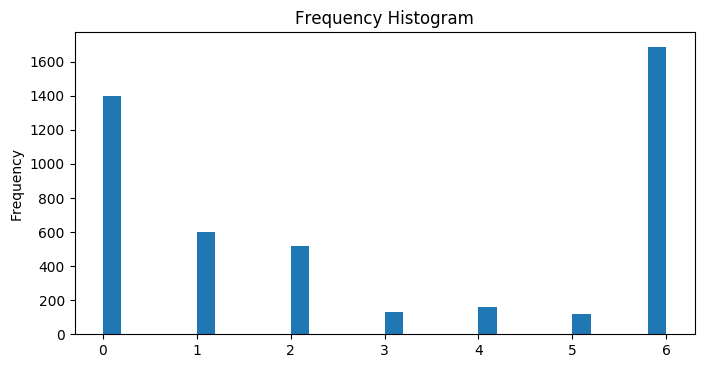

In [5]:
# Plot sales activity for different weekdays ( the datetime function codes Monday = 0 trough Sunday = 6)

plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
x = df["Endday"]
plt.hist(x, bins=30)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

Define functions and hyperparameter dictionary shared by all calculated models

In [37]:
#Define two functions which allow to apply differen preprocessing for text and numeric/categorical features 
#in the pipeline

selectText = FunctionTransformer(lambda x: x["Text"], validate=False)

selectCategorical = FunctionTransformer(lambda x: x[["Product", "Endday",]], validate=False)

selectNumeric = FunctionTransformer(lambda x: x[["Transactions Amount",
                                                 "Pictures",
                                                 "Positive Feedback",
                                                 "Duration"]], validate=False)


dummyCategories = make_column_transformer((OneHotEncoder(), ["Product","Endday"]))


# Create dictionary with classifiers and respective hyperparameters for GridsearchCV
search_space = [
                {"classifier": [LinearRegression()],
                 "classifier__normalize": [True, False]
                 },  
                {"classifier": [ElasticNet()],
                 "classifier__normalize": [True, False],
                 "classifier__alpha": [0.1,0.5,1],
                 "classifier__l1_ratio": [0, 0.5 , 1],
                 },
                 {"classifier": [linear_model.Lasso()],
                 "classifier__normalize": np.logspace(True, False)
                 },
                {"classifier": [linear_model.Ridge()],
                 "classifier__alpha": [0.1, 0.5, 1],
                 "classifier__normalize": [False, True],
                 }]


# Define functions for printing model evaluation metrics for all models 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression_metrics(pred):
    print(f"Mean Absolute Error is {mean_absolute_error(y_test, pred)}")
    #Include Median absolute error to account for possible outliers
    print(f"Median Absolute Error is {median_absolute_error(y_test, pred)}")
    print(f"Mean Absolute Percentage Error (MAPE) is {mean_absolute_percentage_error(y_test, pred).round(2)} %")
    print(f"Max. Error is {max_error(y_test, pred)}")
    print(f"Explained Variance is {explained_variance_score(y_test, pred, multioutput='variance_weighted')}")
    print(f"R2 is {metrics.r2_score(y_test, pred)}")
    
    
numericalFeatures = ["Transactions Amount", "Pictures", "Positive Feedback", "Duration"]

<h3> Model A: Textual features only </h3>

In [47]:
# Vectorize text description
vec = ColumnTransformer([
     ('text', CountVectorizer(stop_words = stopwords), 'Text')],
    remainder="drop")


pipe_text = Pipeline([
    ('features', vec),
    ("scaler", StandardScaler(with_mean=False, with_std=True)),
    ('classifier', LinearRegression())
])

gridCV_text = GridSearchCV(pipe_text, search_space, cv=5,n_jobs=-1)
bestModel_text = gridCV_text.fit(x_train, y_train)
predictions_text = bestModel_text.best_estimator_.predict(x_test)

In [48]:
#Show the resulting best estimator model
bestModel_text.best_estimator_

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text',
                                                  CountVectorizer(stop_words=['aber',
                                                                              'alle',
                                                                              'allem',
                                                                              'allen',
                                                                              'aller',
                                                                              'alles',
                                                                              'als',
                                                                              'also',
                                                                              'am',
                                                                              'an',
                                                                              'ander',
                                                                              'andere',
                                                                              'anderem',
                                                                              'anderen',
                                                                              'anderer',
                                                                              'anderes',
                                                                              'anderm',
                                                                              'andern',
                                                                              'anderr',
                                                                              'anders',
                                                                              'auch',
                                                                              'auf',
                                                                              'aus',
                                                                              'bei',
                                                                              'bin',
                                                                              'bis',
                                                                              'bist',
                                                                              'da',
                                                                              'damit',
                                                                              'dann', ...]),
                                                  'Text')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', ElasticNet(alpha=0.1, l1_ratio=1))])

In [49]:
#Print model evaluation metrics
regression_metrics(predictions_text)

Mean Absolute Error is 2.8551072122253913
Median Absolute Error is 0.807318116176134
Mean Absolute Percentage Error (MAPE) is 2.17 %
Max. Error is 45.87152758507858
Explained Variance is 0.9960929324587088
R2 is 0.9960836669074365


In [8]:
text_labels = bestModel_text.best_estimator_.named_steps['features'].get_feature_names()
eli5.explain_weights(bestModel_text.best_estimator_.named_steps["classifier"], feature_names=text_labels, top=100)

Weight?,Feature
+227.892,<BIAS>
+97.303,text__cdma
+83.148,text__11
+78.896,text__xs
+78.591,text__pro
+65.915,text__nachtgrün
+61.885,text__a2101
+61.714,text__einzigen
+58.281,text__256gb
+57.942,text__a2221


<h3> Model B: Categorical features only </h3>

In [9]:
pipe_cat = Pipeline([
    ('features', FeatureUnion([
            ('numerical_features', Pipeline([
                ('numeric', selectNumeric),
            ])),
            ('categorical_features', Pipeline([
                ('selector', selectCategorical),
                ("dummy", dummyCategories),
            ]))
         ])),
     ("scaler", StandardScaler(with_mean=False, with_std=True)),
    ('classifier', LinearRegression())
])

gridCV_cat = GridSearchCV(pipe_cat, search_space, cv=5,n_jobs=-1)
bestModel_cat = gridCV_cat.fit(x_train, y_train)
predictions_cat = bestModel_cat.best_estimator_.predict(x_test)

In [10]:
#Show the resulting best estimator model
bestModel_cat.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numerical_features',
                                                 Pipeline(steps=[('NUM',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f5d32635e18>))])),
                                                ('categorical_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f5d32635d08>)),
                                                                 ('dummy',
                                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                                   OneHotEncoder(),
                                                                                                   ['Product',
                                                                                                    'Endday'])]))]))])),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', ElasticNet(alpha=0.1, l1_ratio=1))])

In [45]:
#Print estimator metrics
regression_metrics(predictions_cat)

Mean Absolute Error is 26.522077828299512
Median Absolute Error is 18.316723093194142
Mean Absolute Percentage Error (MAPE) is 31.42 %
Max. Error is 175.2798692427025
Explained Variance is 0.9245977097621622
R2 is 0.9238718109214892


In [43]:
#Show feature weights
pvect= dict(bestModel_cat.best_estimator_.named_steps['features'].transformer_list).get('categorical_features').named_steps['dummy']
features_cat = pvect.get_feature_names()
features_cat.extend(numericalFeatures)
eli5.explain_weights(bestModel_cat.best_estimator_.named_steps["classifier"], feature_names=features_cat, top=55)


Weight?,Feature
+232.104,<BIAS>
+62.068,onehotencoder__x1_3
+59.798,onehotencoder__x1_2
+56.557,onehotencoder__x0_iPhone X
+30.176,onehotencoder__x1_1
+24.883,onehotencoder__x0_iPhone 8 Plus
+15.487,onehotencoder__x0_iPhone XS Max
+9.899,Pictures
+7.187,onehotencoder__x1_4
+2.665,onehotencoder__x0_iPhone 8


<h3> Model C: Combined text and categorical features </h3>

In [96]:
# Due to the "NotImplementedError: get_feature_names is not yet supported when using a 'passthrough' transformer."
# it is necessary to run the transformation once using "remainder=drop" in order to get the feature name list (except for the numeric variables)

column_trans = ColumnTransformer(
    [('catgorical', OneHotEncoder(dtype='int'),["Product","Endday"]),
     ('text', CountVectorizer(stop_words = stopwords), 'Text')],
    remainder="drop")

column_trans.fit(x_train)

# This allows to save a list of all features
combinedFeatureNames = column_trans.get_feature_names()

# And extend this list with the numeric features
combinedFeatureNames.extend(numericalFeatures)


# Running the ColumnTransformer using (remainder=passtrough) includes the numeric variables in the output
column_trans = ColumnTransformer(
    [('catgorical', OneHotEncoder(dtype='int'),["Product","Endday"]),
     ('text', CountVectorizer(stop_words = stopwords), 'Text')],
    remainder="passthrough")

# Create pipeline
pipe = Pipeline([("column_trans", column_trans),("scaler", StandardScaler(with_mean=False, with_std=True)),('classifier', LinearRegression())])

# Run 5-fold Gridsearch using the estimators and hyperparameters specified in the "search_space" variable
gridCV = GridSearchCV(pipe, search_space, cv=5,n_jobs=-1)
bestModel = gridCV.fit(x_train, y_train)
predictions = bestModel.best_estimator_.predict(x_test)

In [97]:
#Show the resulting best estimator model
bestModel.best_estimator_

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('catgorical',
                                                  OneHotEncoder(dtype='int'),
                                                  ['Product', 'Endday']),
                                                 ('text',
                                                  CountVectorizer(stop_words=['aber',
                                                                              'alle',
                                                                              'allem',
                                                                              'allen',
                                                                              'aller',
                                                                              'alles',
                                                                              'als',
                                                                              'also',
                                                                              'am',
                                                                              'an',
                                                                              'ander',
                                                                              'andere',
                                                                              'anderem',
                                                                              'anderen',
                                                                              'anderer',
                                                                              'anderes',
                                                                              'anderm',
                                                                              'andern',
                                                                              'anderr',
                                                                              'anders',
                                                                              'auch',
                                                                              'auf',
                                                                              'aus',
                                                                              'bei',
                                                                              'bin',
                                                                              'bis',
                                                                              'bist',
                                                                              'da',
                                                                              'damit',
                                                                              'dann', ...]),
                                                  'Text')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', ElasticNet(alpha=0.1, l1_ratio=1))])

In [98]:
# Calculate Model Metrics
regression_metrics(predictions)

Mean Absolute Error is 1.9188304380647616
Median Absolute Error is 0.810622148073378
Mean Absolute Percentage Error (MAPE) is 2.13 %
Max. Error is 49.31343215920512
Explained Variance is 0.998768271787195
R2 is 0.9987666633696114


In [15]:
eli5.explain_weights(bestModel.best_estimator_.named_steps["classifier"], feature_names=combinedFeatureNames, top=30)

Weight?,Feature
+218.762,<BIAS>
+102.969,catgorical__x0_iPhone 11 Pro
+79.192,text__cdma
+75.559,text__xs
+63.090,text__11
+61.761,text__a2221
+56.651,text__pro
+55.807,text__erst
+54.218,text__einzigen
+51.912,text__fast


<h3> Baseline: Regression Model using a Dummy regressor </h3>

In [107]:
#Setup Dummy Regressor & Pipeline 

dummyRegr = DummyRegressor(strategy="median")
dummyPipe = Pipeline([("column_trans", column_trans),("scaler", StandardScaler(with_mean=False, with_std=True)),('classifier', dummyRegr)])

# Fit Model & predict price of test set
dummyPipe.fit(x_train, y_train)
predictions_dummy = dummyPipe.predict(x_test)

# Calculate Model Metrics
regression_metrics(predictions_dummy)

Mean Absolute Error is 81.6587852494577
Median Absolute Error is 53.0
Mean Absolute Percentage Error (MAPE) is 103.46 %
Max. Error is 657.53
Explained Variance is 0.0
R2 is -0.014266533193686648


<h3> Topic Modeling for highest and lowest performing product's descriptions </h3>

In [16]:
# Split full dataset by product

gb = df.groupby('Product')    
split_products = [gb.get_group(x) for x in gb.groups]


# Create BOW representation for the description text of the bottom & top 20 % of sold prices for earch product category
top20bow=[]
bottom20bow=[]

for product in split_products:
    top20 = product[(product["Price"]>np.percentile(product["Price"], 80))]
    top20bow.extend(top20["Text"].tolist())
    bottom20 = product[(product["Price"]<np.percentile(product["Price"], 20))]
    bottom20bow.extend(bottom20["Text"].tolist())

# function to create BOW-representation of text, remove stopwords and punctuation & convert all text to lowercase

def textPreparation(text):
    text=["".join([l for l in speech if l not in punctuation]) for speech in text] 
    bow = []
    for sentence in text:
        sentence = [word.lower() for word in sentence.split() if word not in stopwords]
        bow.append(sentence)
    return(bow)

# Apply function to texts
    
top20bow = textPreparation(top20bow)
bottom20bow = textPreparation(bottom20bow)

In [104]:
# Define function for performing LDO on prepared texts

def runLDA(texts):
    id2word = corpora.Dictionary(texts)
    mm =[id2word.doc2bow(text) for text in texts]
    lda = models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=50, alpha="auto")
    vis_data = pyLDAvis.gensim.prepare(lda,mm,id2word) 
    for top in lda.print_topics(num_topics=20, num_words=5): 
        print ("\n",top)
    return(vis_data)
    

In [105]:
# Show topics for top 20 percent of items
lda_top20 = runLDA(top20bow)
pyLDAvis.display(lda_top20)


 (37, '0.009*"das" + 0.006*"iphone" + 0.006*"an" + 0.006*"spaß" + 0.005*"guten"')

 (10, '0.017*"auktion" + 0.016*"immer" + 0.015*"schutzhülle" + 0.011*"adapter" + 0.011*"funktioniert"')

 (29, '0.014*"64gb" + 0.013*"benutzt" + 0.012*"ca" + 0.012*"iphone" + 0.012*"hülle"')

 (12, '0.043*"iphone" + 0.029*"64gb" + 0.027*"zustand" + 0.026*"8" + 0.019*"space"')

 (8, '0.039*"handy" + 0.029*"64gb" + 0.023*"iphone" + 0.022*"keine" + 0.021*"apple"')

 (20, '0.014*"ca" + 0.010*"a50" + 0.009*"iphone" + 0.009*"versand" + 0.009*"das"')

 (1, '0.067*"zustand" + 0.036*"fehler" + 0.036*"iphone" + 0.036*"guter" + 0.035*"ladekabel"')

 (24, '0.054*"wurde" + 0.037*"iphone" + 0.034*"zustand" + 0.027*"handy" + 0.027*"funktioniert"')

 (45, '0.020*"versand" + 0.019*"keine" + 0.018*"64gb" + 0.016*"haftung" + 0.014*"garantie"')

 (16, '0.018*"zustand" + 0.016*"iphone" + 0.012*"original" + 0.012*"versand" + 0.011*"ca"')

 (33, '0.032*"iphone" + 0.022*"zustand" + 0.021*"das" + 0.017*"original" + 0.017*"gebra

In [106]:
# Show topics for bottom 20 percent of items
lda_bottom20 = runLDA(bottom20bow)
pyLDAvis.display(lda_bottom20)


 (19, '0.010*"bilderhosting" + 0.009*"trixum" + 0.009*"auktionsvorlagen" + 0.008*"mobiloptimierte" + 0.007*"zustand"')

 (46, '0.020*"a50" + 0.018*"samsung" + 0.017*"galaxy" + 0.014*"versand" + 0.014*"dhl"')

 (2, '0.019*"256gb" + 0.019*"max" + 0.018*"iphone" + 0.018*"xs" + 0.017*"versand"')

 (15, '0.028*"sie" + 0.015*"artikel" + 0.015*"versand" + 0.011*"wir" + 0.011*"dhl"')

 (44, '0.033*"display" + 0.020*"monaten" + 0.019*"galaxy" + 0.018*"s9" + 0.018*"samsung"')

 (47, '0.011*"zustand" + 0.011*"original" + 0.011*"xs" + 0.010*"display" + 0.010*"max"')

 (45, '0.014*"toutsch" + 0.011*"simlock" + 0.010*"beim" + 0.010*"ohne" + 0.010*"das"')

 (30, '0.017*"zustand" + 0.014*"versand" + 0.013*"sie" + 0.010*"gebraucht" + 0.010*"dhl"')

 (13, '0.029*"iphone" + 0.017*"sperre" + 0.016*"display" + 0.015*"garantie" + 0.014*"zustand"')

 (24, '0.019*"ohne" + 0.018*"versand" + 0.018*"simlock" + 0.018*"dhl" + 0.017*"paket"')

 (37, '0.038*"iphone" + 0.015*"space" + 0.015*"zustand" + 0.015*"es" + 

<h3> Proof of concept - Run with dataset not restricted to smartphones </h3>

A combined model is calculated for a smaller, arbitrary dataset including products from other categories in order to gain an estimation of the applicability of the proposed approach for non-smartphone listings.

In [111]:
#Run a combined model with extended dataset

data_varied = {}
error_varied = 0

for fileName in glob("/home/david/ebay/Data/Used_Products/*.json"):
    with open(fileName, "r") as fp:
        tempDict = json.load(fp)
        for k,v in tempDict.items():
            try:
               itemlist = []
               for item in v:
                   itemlist.append(item)
               data_varied[k] = itemlist
            except:
                error_varied += 1
                print(error_varied, k)
print("The retrieved data contains the following" ,len(data_varied.keys()), "keys:",data_varied.keys(),)

dataset_varied = defaultdict(list)

for key in data_varied.keys():
    for item in data_varied[key]:
            dataset_varied["Transactions Amount"].append(int(item["Seller"]["FeedbackScore"]))
            dataset_varied["Positive Feedback"].append(float(item["Seller"]["PositiveFeedbackPercent"]))
            dataset_varied["Price"].append(float(item["CurrentPrice"]["value"]))
            dataset_varied["Pictures"].append(len(item["PictureURL"]))
            dataset_varied["Text"].append(item["Description"])
            dataset_varied["Product"].append(key)
            dataset_varied["Payment Method"].append(item["PaymentMethods"])
            startTime = datetime.datetime.strptime(item["StartTime"], "%Y-%m-%dT%H:%M:%S.%fZ")
            endTime = datetime.datetime.strptime(item["EndTime"], "%Y-%m-%dT%H:%M:%S.%fZ")
            dataset_varied["Duration"].append((endTime-startTime).days)
            dataset_varied["Endday"].append(endTime.weekday())


#Create dataframe with all features
df_varied = pd.DataFrame(dataset_varied,columns=["Product","Transactions Amount", "Pictures","Positive Feedback", "Text","Duration","Endday","Price"])


#Split test and train sets
train_varied, test_varied = train_test_split(df_varied, test_size=0.1)


# Create x and y for test and train data sets
x_train_varied = train.drop(["Price"], axis="columns")
y_train_varied = train.Price

x_test_varied = test.drop(["Price"], axis="columns")
y_test_varied = test.Price

# Print size of dataset and number of columns
print("Train data size: {}".format(train_varied.shape))
print("Test data size: {}".format(test_varied.shape))
print("Complete dataset size: {}".format(df_varied.shape))

# Running the ColumnTransformer using (remainder=passtrough) includes the numeric variables in the output
column_trans_varied = ColumnTransformer(
    [('catgorical', OneHotEncoder(dtype='int'),["Product","Endday"]),
     ('text', CountVectorizer(stop_words = stopwords), 'Text')],
    remainder="passthrough")

# Create pipeline
pipe_varied = Pipeline([("column_trans", column_trans),("scaler", StandardScaler(with_mean=False, with_std=True)),('classifier', LinearRegression())])

# Run 5-fold Gridsearch using the estimators and hyperparameters specified in the "search_space" variable
gridCV_varied = GridSearchCV(pipe_varied, search_space, cv=5,n_jobs=-1)
bestModel_varied = gridCV_varied.fit(x_train_varied, y_train_varied)
predictions_varied = bestModel_varied.best_estimator_.predict(x_test_varied)


The retrieved data contains the following 10 keys: dict_keys(['Ladekabel samsung', 'Rayban', 'Smartwatch', 'dior', 'chanel', 'burberry', 'playstation 4', 'xbox one s', 'nintendo switch', 'nintendo gamecube'])
Train data size: (1143, 8)
Test data size: (128, 8)
Complete dataset size: (1271, 8)


In [112]:
# Calculate Model Metrics
regression_metrics(predictions_varied)

Mean Absolute Error is 1.9188304380647616
Median Absolute Error is 0.810622148073378
Mean Absolute Percentage Error (MAPE) is 2.13 %
Max. Error is 49.31343215920512
Explained Variance is 0.998768271787195
R2 is 0.9987666633696114
